# Investigate metapath-specific p-value adjustements / thresholding

https://github.com/greenelab/hetmech-backend/pull/41

In [1]:
import pandas
import hetio.readwrite

In [2]:
metagraph = hetio.readwrite.read_metagraph('https://github.com/hetio/hetionet/raw/master/hetnet/json/hetionet-v1.0-metagraph.json')

In [3]:
url = 'https://github.com/greenelab/hetmech/raw/34e95b9f72f47cdeba3d51622bee31f79e9a4cb8/explore/bulk-pipeline/archives/metapath-dwpc-stats.tsv'
metapath_df = pandas.read_csv(url, sep='\t')
metapath_df['metapath_obj'] = metapath_df.metapath.map(metagraph.get_metapath)
metapath_df['source'] = metapath_df.metapath_obj.map(lambda x: x.source().identifier)
metapath_df['target'] = metapath_df.metapath_obj.map(lambda x: x.target().identifier)
metapath_df.head(2)

,metapath,length,n_pairs,pc_density,pc_mean,pc_max,dwpc-0.5_raw_mean,metapath_obj,source,target
0,AlD,1,55074,0.065403,0.065403,1,0.003746,(Anatomy - localizes - Disease),Anatomy,Disease
1,AdG,1,8419890,0.012143,0.012143,1,0.000078,(Anatomy - downregulates - Gene),Anatomy,Gene


In [4]:
# url = "https://github.com/hetio/hetionet/raw/b530811ecfac066f5bf4501a1997c1c617f8803b/describe/nodes/metanodes.tsv"
# metanode_df = pandas.read_csv(url, sep='\t')
# metanode_to_count = dict(zip(metanode_df.metanode, metanode_df.nodes))
# metanode_to_count

In [5]:
count_df = metapath_df.groupby(['source', 'target', 'length']).apply(len).rename('n_similar').reset_index()
# count_df['n_source_nodes'] = count_df.source.map(metanode_to_count)
# count_df['n_target_nodes'] = count_df.target.map(metanode_to_count)
count_df.head()

,source,target,length,n_similar
0,Anatomy,Anatomy,2,7
1,Anatomy,Anatomy,3,31
2,Anatomy,Biological Process,2,3
3,Anatomy,Biological Process,3,15
4,Anatomy,Cellular Component,2,3


In [6]:
metapath_df = metapath_df.merge(count_df)

In [7]:
metapath_df['p_threshold'] = metapath_df.eval("100 / (n_pairs * n_similar) ** .5")

In [8]:
metapath_df['p_threshold'].describe()

count    2205.000000
mean        0.021556
std         0.039940
min         0.000338
25%         0.001991
50%         0.006433
75%         0.023980
max         0.729927
Name: p_threshold, dtype: float64

In [9]:
pc_estimate = sum(metapath_df.n_pairs * metapath_df.p_threshold)
f'Estimated rows in the PathCounts table: {pc_estimate:,.0f}'

'Estimated rows in the PathCounts table: 147,488,671'

In [10]:
metapath_df.drop(columns='metapath_obj').sample(n=100)

,metapath,length,n_pairs,pc_density,pc_mean,pc_max,dwpc-0.5_raw_mean,source,target,n_similar,p_threshold
940,CCpG<rGpMF,3,4011644,0.263573,3.757450,3466,4.579930e-05,Cellular Component,Molecular Function,4,0.024964
154,CrCcSE,2,8899168,0.054667,0.115624,28,1.233160e-04,Compound,Side Effect,1,0.033522
713,AeGr>GpPW,3,732444,0.369022,147.971000,39591,9.051880e-05,Anatomy,Pathway,15,0.030169
349,AuG<rGdD,3,55074,0.026800,19.155400,2479,8.769940e-05,Anatomy,Disease,88,0.045424
1461,DtCuGdD,3,18769,0.098567,1.278330,260,3.024090e-04,Disease,Disease,67,0.089175
1593,DaGuCbG,3,2869465,0.019747,0.149657,963,1.349620e-05,Disease,Gene,225,0.003936
1790,DaGuCiPC,3,47265,0.161473,0.700645,176,3.209340e-04,Disease,Pharmacologic Class,13,0.127573
1966,GcGcGiG,3,438693025,0.048967,0.279728,11054,8.074290e-06,Gene,Gene,199,0.000338
695,AeGcGpMF,3,1159368,0.206185,14.988100,6705,8.977130e-05,Anatomy,Molecular Function,15,0.023980
2011,GuAlDpS,3,9173910,0.562122,4.234650,137,8.130350e-05,Gene,Symptom,24,0.006739


In [11]:
metapath_df.query("source == 'Gene'")

,metapath,length,n_pairs,pc_density,pc_mean,pc_max,dwpc-0.5_raw_mean,metapath_obj,source,target,n_similar,p_threshold
19,GcG,1,438693025,0.000281,0.000281,1,0.000021,(Gene - covaries - Gene),Gene,Gene,3,0.002757
20,GiG,1,438693025,0.000671,0.000671,1,0.000018,(Gene - interacts - Gene),Gene,Gene,3,0.002757
21,G<rG,1,438693025,0.000606,0.000606,1,0.000007,(Gene < regulates < Gene),Gene,Gene,3,0.002757
22,GpMF,1,60405380,0.001609,0.001609,1,0.000064,(Gene - participates - Molecular Function),Gene,Molecular Function,1,0.012867
23,GpPW,1,38161790,0.002211,0.002211,1,0.000074,(Gene - participates - Pathway),Gene,Pathway,1,0.016188
210,GdAdG,2,438693025,0.342603,0.790714,30,0.000031,"(Gene - downregulates - Anatomy, Anatomy - dow...",Gene,Gene,32,0.000844
211,GdAeG,2,438693025,0.508159,2.182800,31,0.000025,"(Gene - downregulates - Anatomy, Anatomy - exp...",Gene,Gene,32,0.000844
212,GdAuG,2,438693025,0.344844,0.704828,23,0.000031,"(Gene - downregulates - Anatomy, Anatomy - upr...",Gene,Gene,32,0.000844
213,GeAeG,2,438693025,0.712598,10.441400,83,0.000036,"(Gene - expresses - Anatomy, Anatomy - express...",Gene,Gene,32,0.000844
214,GeAuG,2,438693025,0.540892,2.148370,24,0.000027,"(Gene - expresses - Anatomy, Anatomy - upregul...",Gene,Gene,32,0.000844


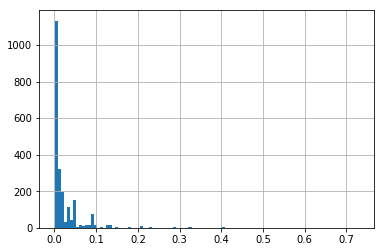

In [12]:
%matplotlib inline
metapath_df['p_threshold'].hist(bins=100)

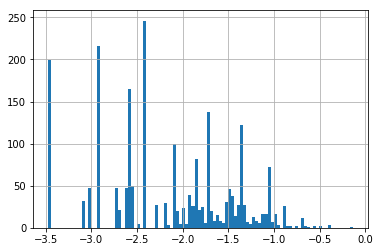

In [13]:
import math
metapath_df['p_threshold'].map(math.log10).hist(bins=100)